# Wages model

import warnings
warnings.filterwarnings("error")

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pymc.sampling.jax as pmjax
import jax
import re
from io import StringIO 
import sys

# Configurations
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Set random seed
RANDOM_SEED = 230810
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# Run this cell to set up ["CPU"] as the default backend for JAX. NOTE: Any change to the backend requires a restart of the kernel.
# CPU seems to be faster than GPU for this model
jax.config.update('jax_platform_name', 'cpu')
print(f"JAX default backend: {jax.default_backend()}")

JAX default backend: cpu


## a. Aux Functions

In [3]:
# Create a context manager that captures stdout output (Numpyro prints to stdout)
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [4]:
def sampling_output(sampling_info, nchains, ndraws, ntunes):
    """ Function to organize the sampling info after the NUTS sampler has run."""
    sampling_metadata = {}
    for location, stage in enumerate(["Compilation", "Sampling", "Transformation"]):
        stage_duration = re.search(fr'{stage} time =\s+(\d+:\d+:\d+\.\d+)', sampling_info[(location * 2) + 1]).group(1)
        sampling_metadata[f"{stage}_time"] = stage_duration
        if stage == "Sampling":
            sampling_time_seconds = pd.to_timedelta(stage_duration).total_seconds()
            sampling_metadata["AvgIt/s"] = round(((ndraws + ntunes) * nchains) / sampling_time_seconds, 2)

    return sampling_metadata

## 1. Prepare Data

In [5]:
# Import data
data = pd.read_csv("slid_wages_2011.csv")

In [6]:
# Filter out columns of interest
df = data[["industry","occup","ftpt","sex","self_emp","union","public_sector","multiple_jobs","salary"]]

# Convert to categorical
df = df.rename(columns={"industry":"ind", "occup": "occ"})
df["ptm"] = pd.factorize(df["ftpt"])[0]
df["gender"] = pd.factorize(df["sex"])[0]
df["self"] = pd.factorize(df["self_emp"])[0]
df["union"] = pd.factorize(df["union"])[0]
df["public_sector"] = pd.factorize(df["public_sector"])[0]
df["multiple_jobs"] = pd.factorize(df["multiple_jobs"])[0]

# Drop columns
df = df.drop(columns=["ftpt","sex","self_emp"])
df.head(3)

,ind,occ,union,public_sector,multiple_jobs,salary,ptm,gender,self
0,construction,middle management,0,0,0,54352.891156,0,0,0
1,"information, culture and recreation",other trades,1,1,0,41096.088435,1,0,0
2,trade,"wholesale, technical, insurance, real estate s...",0,0,0,79540.816327,0,0,0


In [7]:
# Dataset description
df.describe()

,union,public_sector,multiple_jobs,salary,ptm,gender,self
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,0.360407,0.312443,0.111086,74584.046801,0.092308,0.495249,0.039140
std,0.480173,0.463542,0.314274,47617.238237,0.289493,0.500034,0.193951
min,0.000000,0.000000,0.000000,2386.224490,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,43747.448980,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,66284.013605,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,96111.819728,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,649583.333333,1.000000,1.000000,1.000000


In [8]:
def hierarchical_normal(name, model):
    with model:
        mean = pm.Normal(f'{name}_mean', 0, 1)
        sd = pm.HalfNormal(f'{name}_sd', 1)
    return model

def make_priors(model):
    model = hierarchical_normal('a', model)
    model = hierarchical_normal('b', model)
    return model


model = pm.Model()
model = make_priors(model)
with model:
    c = pm.Normal('c', model['a_mean'] + model['b_mean'])

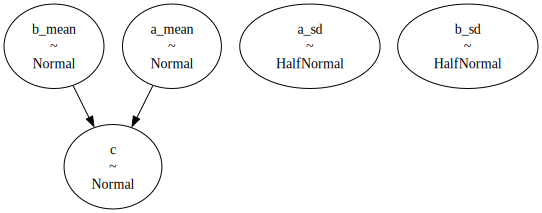

In [24]:
pm.model_to_graphviz(model)

In [25]:
dataset = {
    "ind": {
        "type": "parameter",
        "element": "intercept",
        "data": pd.factorize(df["ind"])[0],
        "cats": pd.factorize(df["ind"])[1],
        "dims": "ind"
    },
    "occ": {
        "type": "parameter",
        "element": "intercept",
        "data": pd.factorize(df["occ"])[0],
        "cats": pd.factorize(df["occ"])[1],
        "dims": "occ"
    },
    "ptm": {
        "type": "parameter",
        "element": "slope",
        "data": pd.factorize(df["ptm"])[0],
        "cats": pd.factorize(df["ptm"])[1],
        "dims": "ind"        
    },
    "salary": {
        "type": "target",
        "element": None,
        "data": df["salary"].values,
        "cats": None,
        "dims": "obs"
    }
}

# Create coordinates
COORDS = {
    "obs": np.arange(len(df)),
    "ind": dataset["ind"]["cats"],
    "occ": dataset["occ"]["cats"],
}

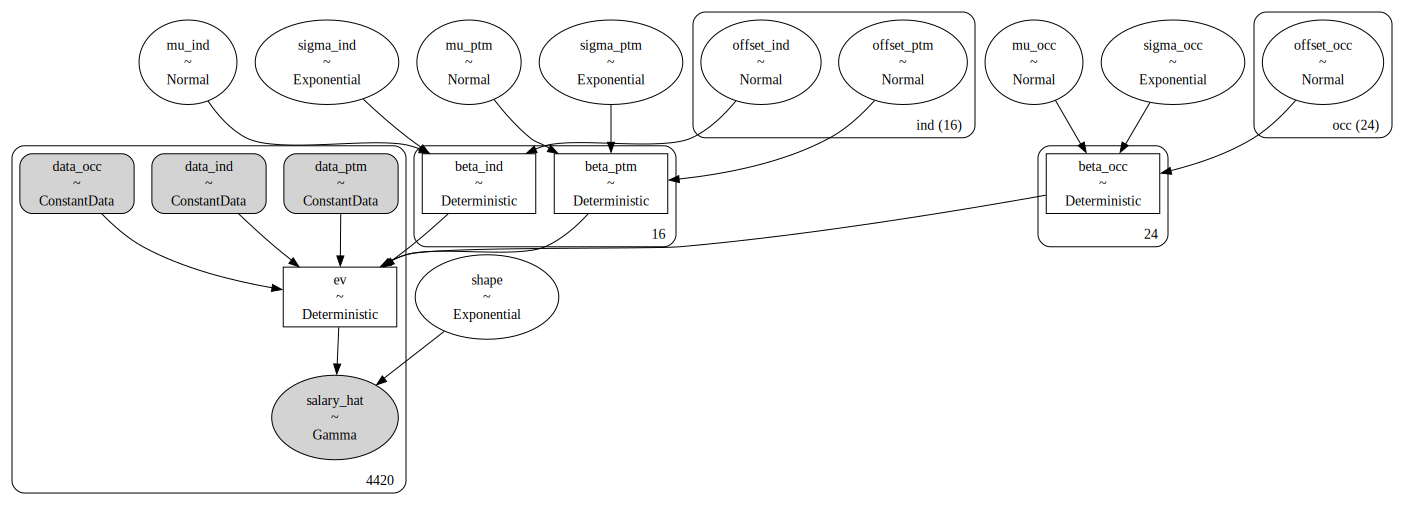

In [31]:
def make_data(dataset, model):
    with model:
        model_data = {}
        for variable, data in dataset.items():
            if data["type"] == "parameter":
                model_data[f"{variable}"] = pm.Data(f"data_{variable}", data["data"], mutable=False)
    return model, model_data

def make_hyperpriors(model):
    with model:
        for variable, data in dataset.items():
            if data["type"] == "parameter":
                mu = pm.Normal(f'mu_{variable}', mu=0, sigma=10)
                sigma = pm.Exponential(f'sigma_{variable}', lam=10)
    return model

def make_priors(model, param="centered"):
    with model:
        for variable, data in dataset.items():
            if data["type"] == "parameter":
                # Get hyperpriors
                mu = [ var for var in model.free_RVs if f"mu_{variable}" in var.name ][0]
                sigma = [ var for var in model.free_RVs if f"sigma_{variable}" in var.name ][0]

                # Define if centered or non-centered parametization
                if param == "centered":
                    pm.Normal(f"beta_{variable}", mu=mu, sigma=sigma, dims=data["dims"])
                elif param == "non-centered":
                    offset = pm.Normal(f"offset_{variable}", mu=0, sigma=1, dims=data["dims"])
                    pm.Deterministic(f"beta_{variable}", mu + sigma * offset)
    return model

def make_expectedval(model, model_data=None):
    mu = 0
    with model:
        for variable, data in dataset.items():
            if data["type"] == "parameter":
                # Set parameter
                parameter = [ var for var in model.unobserved_RVs if f"beta_{variable}" in var.name ][0]

                # Define if intercept or slope
                if data["element"] == "intercept":
                    beta = 1
                elif data["element"] == "slope":
                    beta = model_data[f"{variable}"]
                    
                # Define define dimensions and parameter contribution to expected value
                if data["dims"] == None:
                    mu += parameter * beta
                else:
                    mu += parameter[model_data[f"{data['dims']}"]] * beta
        pm.Deterministic("ev", pm.math.exp(mu))
    return model

def make_likelihood(model):
    with model:
        target = [ data["data"] for _, data in dataset.items() if data["type"]=="target" ][0]
        shape = pm.Exponential("shape", lam=10)
        mu = [ var for var in model.unobserved_RVs if "ev" in var.name ][0]
        y = pm.Gamma("salary_hat", alpha=shape, beta=shape/mu, observed=target)
    return model

model = pm.Model(coords=COORDS)
model, model_data = make_data(dataset, model)
model = make_hyperpriors(model)
model = make_priors(model, "non-centered")
model = make_expectedval(model, model_data)
model = make_likelihood(model)

pm.model_to_graphviz(model)      

In [32]:
with model:
    trace = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.137375
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
pm.summary(trace, var_names=["~ev"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ind,4.128,7.288,-7.076,19.629,1.825,1.425,23.0,33.0,1.16
mu_occ,3.079,7.400,-10.376,17.398,2.760,2.037,8.0,18.0,1.46
mu_ptm,3.919,7.465,-7.967,18.811,2.423,1.769,10.0,35.0,1.37
beta_ind[construction],4.166,7.284,-7.017,19.638,1.823,1.425,23.0,33.0,1.16
"beta_ind[information, culture and recreation]",4.095,7.288,-7.130,19.610,1.826,1.424,23.0,33.0,1.16
...,...,...,...,...,...,...,...,...,...
beta_ptm[agriculture],3.872,7.464,-7.962,18.824,2.421,1.767,10.0,35.0,1.37
sigma_ind,0.165,0.088,0.020,0.294,0.011,0.008,42.0,44.0,1.07
sigma_occ,0.252,0.040,0.186,0.324,0.002,0.001,513.0,686.0,1.01
sigma_ptm,0.151,0.090,0.016,0.286,0.012,0.008,49.0,73.0,1.07


In [46]:
mu += p
mu

matrix([[1, 2, 3]])

In [72]:
model.free_RVs

[mu_ind ~ Normal(0, 10),
 sigma_ind ~ Exponential(f()),
 mu_occ ~ Normal(0, 10),
 sigma_occ ~ Exponential(f()),
 beta_ind ~ Normal(mu_ind, sigma_ind),
 beta_occ ~ Normal(mu_occ, sigma_occ)]

In [18]:
pm.model_to_graphviz(model_obj)

In [19]:
model_h = hierarchical_normal('var', model_obj)

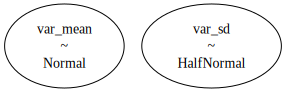

In [20]:
pm.model_to_graphviz(model_h)

In [ ]:
def make_priors(model):
    model = hierarchical_normal('a', model)
    model = hierarchical_normal('b', model)
    return model

def model_version_one():
    model = pm.Model()
    model = make_priors(model)
    with model:
        c = pm.Normal('c', model['a'] + model['b'], observed=data)
    return model

## 2. Model

In [14]:
# Create dimension vectors
intercepts = ["ind", "occ"]
parameters = intercepts + ["ptm","self","gender"]
dimensions = {}
for parameter in parameters:
    dimensions[parameter] = {}
    dimensions[parameter]["idx"], dimensions[parameter]["cats"] = pd.factorize(df[parameter])

salaries = df["salary"].values



In [15]:
baseModel = pm.Model(coords=COORDS)

In [16]:
pm.model_to_graphviz(baseModel)

In [17]:
with baseModel:
    # Data
    ind = pm.MutableData("ind", dimensions["ind"]["idx"])
    occ = pm.MutableData("occ", dimensions["occ"]["idx"])

    # Priors
    avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
    avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")

    # Expected value
    ev = pm.Deterministic('ev', avg_salary_ind[ind] + avg_salary_occ[occ])
    mu = pm.Deterministic('mu',pm.math.exp(ev))

    # Model error
    shape = pm.Exponential("shape", lam=1)

    # Likelihood
    salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)   

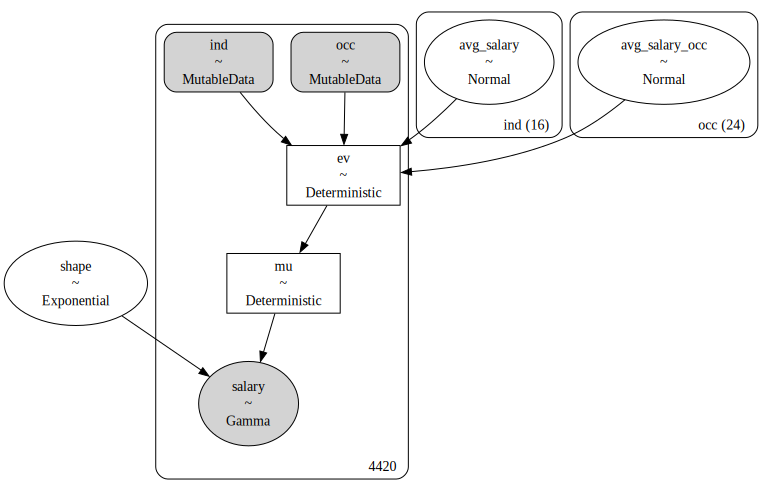

In [18]:
pm.model_to_graphviz(baseModel)

In [19]:
with baseModel:
    # # Data
    # ptm = pm.MutableData("ba", dimensions["ptm"]["idx"])

    # Priors
    avg_salary_ptm = pm.Normal("avg_salary_ptm", mu=0, sigma=10, dims="ind")

    # # Expected value
    # ev += avg_salary_ptm[ind]

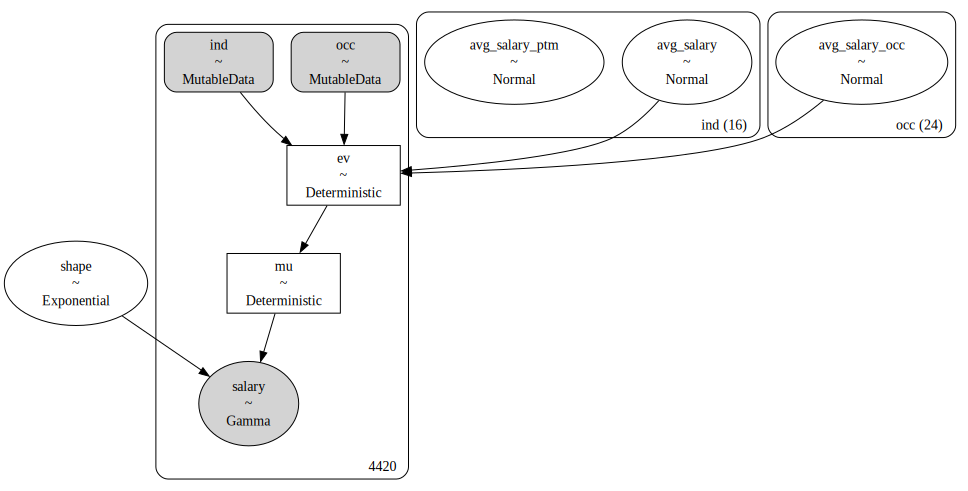

In [20]:
pm.model_to_graphviz(baseModel)

In [26]:
baseModel.register_rv('ev_f', pm.Deterministic('ev_2', avg_salary_ind[ind] + avg_salary_occ[occ] + avg_salary_ptm[ind], model=baseModel))

AttributeError: 'TensorVariable' object has no attribute 'endswith'

In [76]:
def base_model(model_name, COORDS):
    with pm.Model(coords=COORDS) as model_name:
        
    return model_name

In [77]:
a = base_model("bla", COORDS)

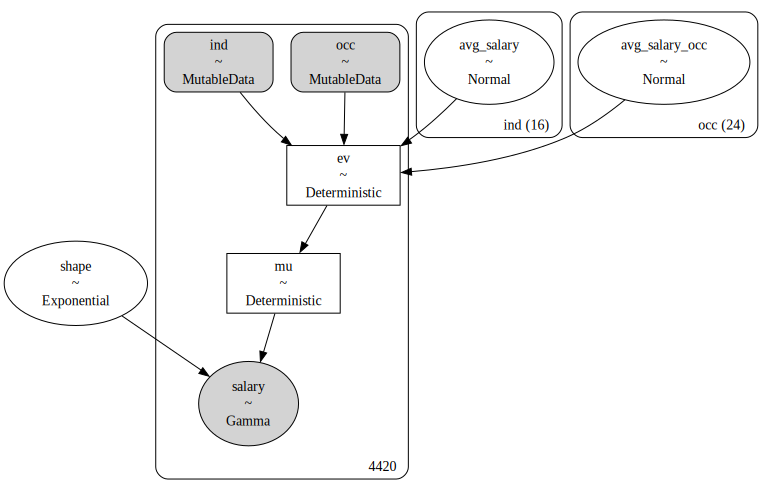

In [78]:
pm.model_to_graphviz(a)

In [79]:
with a:
    # Data
    ptm = pm.MutableData("ba", dimensions["ptm"]["idx"])

    # Priors
    avg_salary_ptm = pm.Normal("avg_salary_ptm", mu=0, sigma=10, dims="ind")

    # Expected value
    a.ev += avg_salary_ptm[a.ind]
    a.mu = pm.math.exp(a.ev)

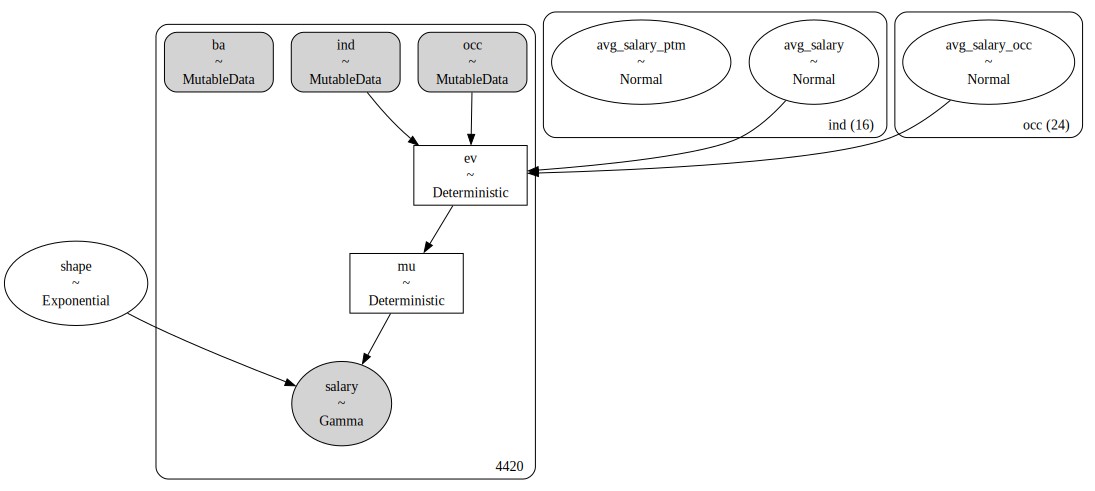

In [80]:
pm.model_to_graphviz(a)

In [61]:
vars = []
for id_var, variable in enumerate(["ptm","self","gender"]):
    vars.append(variable)
    with pm.Model(coords=COORDS) as model:
        # Parameter definition
        parameter_definition = { 
            f"{variable}": {
                "data": pm.MutableData(f"data_{variable}", dimensions[variable]["idx"]),
                "prior": pm.Normal(f"beta_{variable}", mu=0, sigma=10, dims="ind")
                }
            for variable in vars }

        # Data
        ind = pm.MutableData("ind", dimensions["ind"]["idx"])
        occ = pm.MutableData("occ", dimensions["occ"]["idx"])

        # Priors
        avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
        avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")

        # Expected value
        mu = avg_salary_ind[ind] + avg_salary_occ[occ]
        for parameter in parameter_definition.keys():
            mu += parameter_definition[parameter]["prior"][ind] * parameter_definition[parameter]["data"]

        mu = pm.math.exp(mu)

        # Model error
        shape = pm.Exponential("sigma", 1)

        # Likelihood
        salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)

        # Sample
        with Capturing() as sampling_info:
            trace = pmjax.sample_numpyro_nuts(10, tune=10, target_accept=0.95, progressbar=False)

        # Save trace
        trace.to_netcdf(f"trace_{'_'.join(vars)}.nc")

        # Save sampling metadata
        sampling_metadata = sampling_output(sampling_info, 10, 10, 10)
        
    
    
    # print(f"Model for {variable} created. {parameter_definition.keys()}")
    # print(pm.summary(trace))#.to_csv(f"summary_{variable}.csv")
    # gv = pm.model_to_graphviz(model)
    # gv.format = 'png'
    # gv.render(filename=f'model_graph_{id_var}')

In [62]:
sampling_info

['Compiling...',
 'Compilation time =  0:00:01.620980',
 'Sampling...',
 'Sampling time =  0:00:03.757347',
 'Transforming variables...',
 'Transformation time =  0:00:00.006690']

In [58]:


data = [
    'Compiling...',
    'Compilation time =  0:00:01.685618',
    'Sampling...',
    'Sampling time =  0:00:03.826616',
    'Transforming variables...',
    'Transformation time =  0:00:00.009453'
]

pattern = r'Compilation time =\s+(\d)+:\d+:(\d)+\.(\d+)'

compilation_times = []

for line in data:
    match = re.search(pattern, line)
    if match:
        compilation_times.append(match.group(3))

print(compilation_times)

['685618']


'0:00:03.826616'

In [18]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

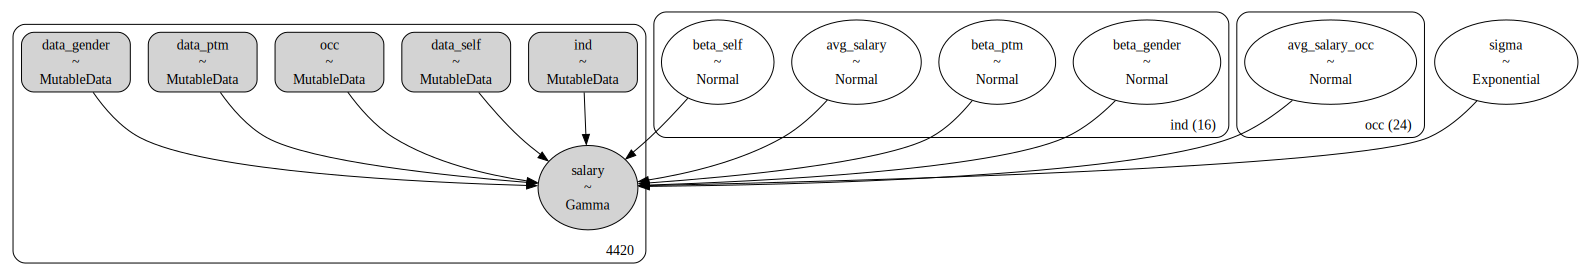

In [8]:
pm.model_to_graphviz(model)

In [10]:
pm.summary(trace, var_names=["beta_"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ptm[construction],-0.686,0.175,-1.027,-0.361,0.003,0.002,3747.0,3089.0,1.0
"beta_ptm[information, culture and recreation]",-0.849,0.124,-1.086,-0.622,0.002,0.001,4153.0,3243.0,1.0
beta_ptm[trade],-0.770,0.053,-0.869,-0.671,0.001,0.001,4293.0,2545.0,1.0
beta_ptm[transportation and warehousing],-0.769,0.107,-0.977,-0.577,0.002,0.001,3816.0,3292.0,1.0
beta_ptm[health care and social assistance],-0.513,0.054,-0.609,-0.403,0.001,0.001,4258.0,2959.0,1.0
beta_ptm[accommodation and food services],-0.481,0.095,-0.658,-0.302,0.002,0.001,3303.0,2815.0,1.0
"beta_ptm[professional, scientific and technical services]",-0.175,0.183,-0.493,0.186,0.003,0.002,3615.0,3085.0,1.0
beta_ptm[public administration],-0.849,0.128,-1.081,-0.597,0.002,0.001,4345.0,2962.0,1.0
beta_ptm[manufacturing],-0.650,0.121,-0.881,-0.428,0.002,0.001,4164.0,2809.0,1.0
"beta_ptm[finance, insurance, real estate and leasing]",-0.606,0.135,-0.858,-0.344,0.002,0.002,4085.0,2641.0,1.0


In [14]:
with model:
    # Sample
    trace = pmjax.sample_numpyro_nuts(draws=10000, tune=10000, target_accept=0.95, chains=10)

Compiling...


DeprecationWarning: jax.numpy.product is deprecated. Use jax.numpy.prod

In [7]:
with pm.Model(coords=COORDS) as model:
        # Data
        ind = pm.MutableData("ind", dimensions["ind"]["idx"])
        occ = pm.MutableData("occ", dimensions["occ"]["idx"])
        ptm = pm.MutableData("ptm", dimensions["ptm"]["idx"])

        # Priors
        avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
        avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")
        beta_ptm = pm.Normal("beta_ptm", mu=0, sigma=10, dims="ind")

        # Expected value
        mu = avg_salary_ind[ind] + avg_salary_occ[occ] + beta_ptm[ind] * ptm
        mu = pm.math.exp(mu)

        # Model error
        shape = pm.Exponential("sigma", 1)

        # Likelihood
        salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)

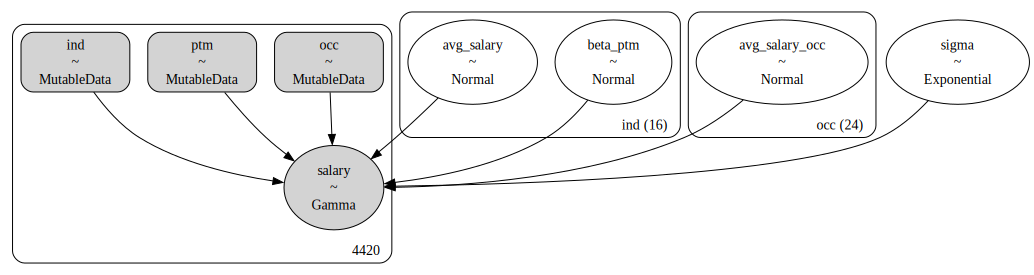

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    # Sample
    trace = pmjax.sample_numpyro_nuts(draws=10000, tune=10000, target_accept=0.95, chains=10)

Compiling...
Compilation time =  0:00:05.560267
Sampling...


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]